In [8]:
# Use the Sharpe Ratio (max return for lowest risk)
import yfinance as yf 
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [10]:
# Define the list of tickers 
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [12]:
# Set the end date
end_date = datetime.today()

In [16]:
# Set the start date to 5 years ago 
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2019-12-03 18:52:36.933226


In [20]:
# Create an empty DataFrame to store the adjusted close prices 
adj_close_df = pd.DataFrame()

In [22]:
# Download the close prices for each ticker 
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [24]:
# Display the DataFrame
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-12-03  286.548492  73.807060  139.110001  195.224823  145.771820
2019-12-04  288.316437  73.658264  138.919998  196.213486  146.715088
2019-12-05  288.834961  73.579536  139.000000  196.601181  146.927826
2019-12-06  291.473114  73.483238  137.619995  198.704529  148.231705
2019-12-09  290.556763  73.500740  137.580002  197.803162  147.760086
...                ...        ...         ...         ...         ...
2024-11-22  595.510010  72.589996  249.839996  505.790009  296.510010
2024-11-25  597.530029  73.260002  242.479996  506.589996  297.959991
2024-11-26  600.650024  73.129997  242.949997  509.309998  299.049988
2024-11-27  598.830017  73.330002  243.490005  505.299988  298.200012
2024-11-29  602.549988  73.599998  245.589996  509.739990  299.859985

[1257 rows x 5 columns]


In [28]:
# Calculate the lognormal returns for each ticker 
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [30]:
# Drop any missing values 
log_returns = log_returns.dropna()

In [32]:
# Calculate the covarience matrix using annualised log returns 
cov_matrix = log_returns.cov()*252

In [93]:
# Calculate the portfolio standard deviation 
def standard_deviation(weights, cov_matrix):
    variance = weights.T@cov_matrix@weights
    return np.sqrt(variance)

In [89]:
# Calculate the expected return 
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252  # Annualized return

In [85]:
# Calculate the Sharpe Ratio (measures the risk-adjusted return of an investment, indicating how much excess return is earned for each unit of risk taken.)
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [ ]:
# Set the risk-free rate (use FRED API but in this case I just assumed the rate)
risk_free_rate = 0.02 


In [40]:
# Define the function to minimise (negative Sharpe Ratio)
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [44]:
# Set the constraints and bounds 
# Constraints making sure all the weights of the portfolio sum up to 1 
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
# Bounds,lower bound means we cannot go short on any of these assets, upper bound to restrict
bounds = {(0, 0.5) for _ in range(len(tickers))}

In [50]:
# Set the initial weights 
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [95]:
# Optimise the weights to max the Sharpe Ratio
optimized_results = minimize(
    neg_sharpe_ratio,
    initial_weights,
    args=(log_returns, cov_matrix, risk_free_rate),
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

In [97]:
# Get the optimal weights 
optimal_weights = optimized_results.x

In [99]:
# Display the analytics of the optimal portfolio
print('Optimal Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight:.4f}')

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected Annual Return: {optimal_portfolio_return:.4f}')
print(f'Expected Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {optimal_sharpe_ratio:.4f}')


Optimal Weights:
SPY: 0.0312
BND: 0.0000
GLD: 0.5000
QQQ: 0.4688
VTI: 0.0000

Expected Annual Return: 0.1519
Expected Volatility: 0.1588
Sharpe Ratio: 0.8310


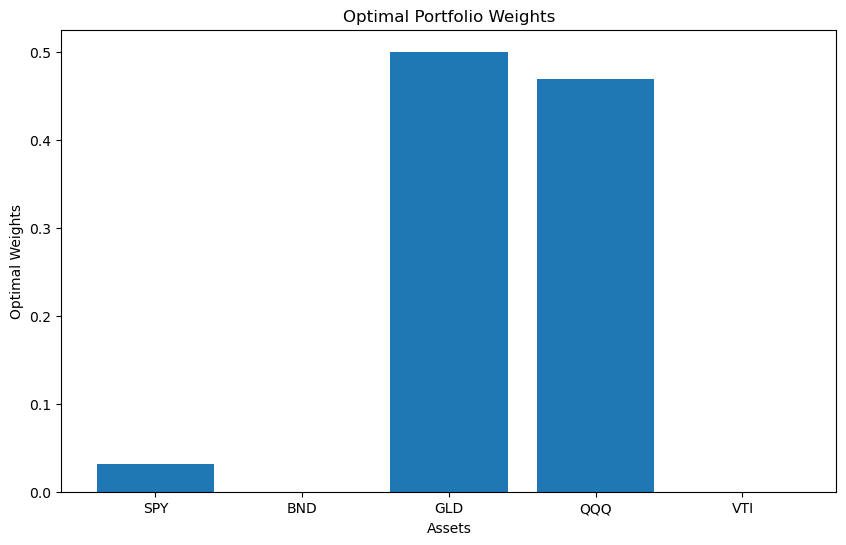

In [103]:
# Display the final portfolio in a plot 
import matplotlib.pyplot as plt 

# Create a bar chart of the optimal weights 
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

# Add labels and a title 
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

#Display the chart 
plt.show()